# Convert BUP20 Annotation to YOLOv8 Format

----------------------------------

Make sure `datasets/sweet-pepper-seg` exists before running the cells below. This code adds more data to the dataset.

In [1]:
DATASET_PATH = "/veriler/salih/Desktop/hiwi/hiwi2_ws/bag/dataset_620_red_yellow_cart_only"

-------------------------------------

In [2]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import os

def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text  # or whatever

from json2yolo import *
def convert_coco_json(json_dir='../coco/annotations/', use_segments=False, cls91to80=False):
    save_dir = make_dirs()  # output directory
    coco80 = coco91_to_coco80_class()

    # Import json
    json_file = Path(json_dir + "/dataset_620_red_yellow_cart_only_coco.json")

    fn = Path(save_dir) / 'labels' / json_file.stem.replace('instances_', '')  # folder name
    fn.mkdir()
    with open(json_file) as f:
        data = json.load(f)

    # Create image dict
    images = {'%g' % x['id']: x for x in data['images']}
    # Create image-annotations dict
    imgToAnns = defaultdict(list)
    for ann in data['annotations']:
        imgToAnns[ann['image_id']].append(ann)

    # Write labels file
    for img_id, anns in tqdm(imgToAnns.items(), desc=f'Annotations {json_file}'):
        img = images['%g' % img_id]
        h, w, f = img['height'], img['width'], img['file_name']

        bboxes = []
        segments = []
        for ann in anns:
            if ann['iscrowd']:
                continue
            # The COCO box format is [top left x, top left y, width, height]
            box = np.array(ann['bbox'], dtype=np.float64)
            box[:2] += box[2:] / 2  # xy top-left corner to center
            box[[0, 2]] /= w  # normalize x
            box[[1, 3]] /= h  # normalize y
            if box[2] <= 0 or box[3] <= 0:  # if w <= 0 and h <= 0
                continue
            
            # available categories 1 2 3 4 5 6 # <-------------------------------------------------------------- SKIP IF NOT FRUIT
            # 1 -> fruit
            # 2 -> ???? -> REMOVE
            # 3 -> fruit stalk -> REMOVE
            # 4 -> fruit stalk -> REMOVE
            # 5 -> ???? -> REMOVE
            # 6 -> fruit stalk -> REMOVE
            if ann['category_id'] != 1: continue 

            cls = coco80[ann['category_id'] - 1] if cls91to80 else ann['category_id'] - 1  # class

            cls = 49 # <------------------------------------------------------------------------------ SET ALL LABELS TO "ORANGE"
            box = [cls] + box.tolist()
            if box not in bboxes:
                bboxes.append(box)
            # Segments
            if use_segments:
                if len(ann['segmentation']) > 1:
                    s = merge_multi_segment(ann['segmentation'])
                    s = (np.concatenate(s, axis=0) / np.array([w, h])).reshape(-1).tolist()
                else:
                    s = [j for i in ann['segmentation'] for j in i]  # all segments concatenated
                    s = (np.array(s).reshape(-1, 2) / np.array([w, h])).reshape(-1).tolist()
                s = [cls] + s
                if s not in segments:
                    segments.append(s)

        # Write
        with open((fn / f).with_suffix('.txt'), 'a') as file:
            for i in range(len(bboxes)):
                line = *(segments[i] if use_segments else bboxes[i]),  # cls, box or segments
                file.write(('%g ' * len(line)).rstrip() % line + '\n')

In [3]:
with open(DATASET_PATH + "/dataset_620_red_yellow_cart_only_coco.json", 'r') as f:
  metadata = json.load(f)

m_images = metadata["images"]
m_categories = metadata["categories"]
m_annotations = metadata["annotations"]

#############################################

new_metadata = {}
img_id_to_file_name = {}

for image in m_images:
    if image["file_name"] not in new_metadata:
      m = {}
      m["id"] = image["id"]
      m["width"] = image["width"]
      m["height"] = image["height"]
      m["annotations"] = []
      new_metadata[ image["file_name"] ] = m
      img_id_to_file_name[image["id"]] = image["file_name"]
    else:
       print("DUPLICATE!")

#############################################

for annotation in m_annotations:
    file_name = img_id_to_file_name[ annotation["image_id"] ]
    new_metadata[file_name]["annotations"].append(annotation)


In [4]:
convert_coco_json(json_dir=DATASET_PATH, use_segments=True)

Annotations /veriler/salih/Desktop/hiwi/hiwi2_ws/bag/dataset_620_red_yellow_cart_only/dataset_620_red_yellow_cart_only_coco.json: 100%|██████████| 619/619 [00:00<00:00, 1339.50it/s]


In [5]:
!mv new_dir/labels/dataset_620_red_yellow_cart_only_coco/*.txt "datasets/sweet-pepper-seg/labels/train/"
!rmdir new_dir/images
!rmdir new_dir/labels/dataset_620_red_yellow_cart_only_coco
!rmdir new_dir/labels
!rmdir new_dir

In [6]:
import glob
import shutil

for file in glob.glob(DATASET_PATH + "/*.png"):
    dest = "datasets/sweet-pepper-seg/images/train/"
    shutil.copy(file, dest)

## Test COCO to YOLOV8 Conversion

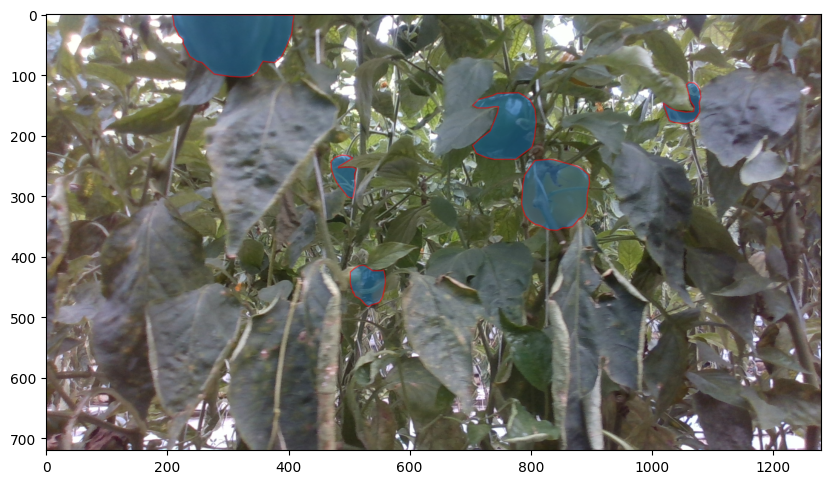

In [7]:
sample_name = "_Color_1607626139692.28735351562500"
sample_name = "_Color_1607626297604.52880859375000"
sample_name = "_Color_1607626825900.50976562500000"
#sample_name = "_Color_1607627036049.79711914062500"
sample_name = "_Color_1607627264545.31469726562500"
sample_name = "png_Color_1607625808257.37133789062500"

img_path = "datasets/sweet-pepper-seg/images/train/" + sample_name + ".png"
ann_path = "datasets/sweet-pepper-seg/labels/train/" + sample_name + ".txt"

image = plt.imread(img_path)

annotation_poly = []
annotation_label = []
with open(ann_path) as file:
    for line in file:
        annotation_label.append( int(line.split(" ")[0]) )
        y = np.array(line.split(" ")[1:]).astype(np.float32)
        annotation_poly.append(y)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(image)

height = image.shape[0]
width = image.shape[1]

image_shape = np.array([width, height]).reshape((-1,2))

for poly, label in zip(annotation_poly, annotation_label):
    p = Polygon(poly.reshape((-1,2)) * image_shape, edgecolor = 'r', fill = True, alpha=0.5)
    ax.add_patch(p)